*Привет!*


*Меня зовут Кирилл, я буду проводить ревью твоего проекта.*


*Предлагаю общаться на «ты» :)* 


*Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе стать отличным специалистом. Ниже ты найдешь мои комментарии, оформленные вот так: **«Комментарий ревьюера 🛸:…»***


*Помни, что все мои комментарии являются рекомендациями, а не требованиями – только ты решаешь, как сделать этот проект лучше.*


<div class="alert alert-danger">
<b>Комментарий ревьюера ❌:</b> </div>
    
Так выделены самые важные замечания. Эти замечания очень важные! Их нужно обязательно отработать, перед тем как показывать работу другим специалистам по Data Science.
    


<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> </div>
    
Так выделены небольшие замечания. Я надеюсь, что их ты тоже учтешь - твой проект от этого станет только лучше.
    
<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> </div>
    
Так я выделяю правильные и верные действия, а так же все остальные комментарии.


## Описание проекта

**Matching** - это задача поиска и сопоставления двух объектов из разных наборов данных. 

Необходимо разработать алгоритм, который для всех товаров из **validation.csv** предложит несколько вариантов наиболее похожих товаров из base и оценить качество алгоритма по метрике **accuracy@5**.

 Описание:

***base.csv*** - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
***train.csv*** - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …), вектор признаков и id товара из base.csv, который максимально похож на него (по мнению экспертов).
***validation.csv*** - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv
***validation_answer.csv*** - правильные ответы к предыдущему файлу

### Вывод

Исходные данные имеют хорошее качество. 
Пропуски и дубликаты - отсутствуют. 
Значение целевой метрики `accuracy@5` = *71.797* получено с использованием модели ***FAISS*** с индексом 
***IndexFlatL2***.<br> 
Для работы был выбран индекс ***IndexFlatL2*** в связи с кратно меньшим временем работы, 
в сравнении с индексом ***IndexIVFFlat***, при практически одинаковых показателях метрики. 

| Индекс FAISS  | accuracy@5 | Время (сек.) |
|:--------------|-----------:|-------------:|
| IndexFlatL2   |     71.798 |       239.22 |
| IndexIVFFlat  |     71.797 |      2221.57 |

Масштабирование было выполнено с применением ***RobustScaler***.<br>
Признаки с ненормальным распределением были удалены, за исключением двух признаков, удаление которых оказывало негативное влияние на метрику.
Попытка уменьшить размерность не привела к улучшению результата.

<a id='section_0'></a>
### [Оглавление](#section_0)<br>
[1. Импорты, настройки и загрузка данных](#section_1)<br>
-    [1.1 Функции](#section_1.1)<br>
-    [1.2 Загрузка данных](#section_1.2)<br>

[2. Анализ и предобработка данных](#section_2)<br>
[3. Подготовка и выбор моделей](#section_3)<br>
[4. Уменьшение размерности](#section_4)<br>
[5. Проверка на Валидационной выборкее](#section_5)<br>
[6. Итоговый вывод](#section_6)<br>


<a id='section_1'></a>
## Импорты, настройки и загрузка данных

In [1]:
import faiss
import numpy as np
import pandas as pd
import seaborn as sns
import sweetviz as sv
import time
import warnings

from matplotlib import pyplot as plt
from phik import phik_matrix
from sklearn.decomposition import IncrementalPCA, PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import (MaxAbsScaler, MinMaxScaler, 
                                   PowerTransformer, RobustScaler, 
                                   QuantileTransformer)
from tqdm import tqdm


# константы
RANDOM_STATE = 13
K = 5

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Все необходимые импорты перенесены в начало. Есть описание проекта и используемых данных.</div>


In [2]:
# !pip install faiss-cpu -q
# !pip install sweetviz -q
# !pip install phik -q
# !pip install shap -q

In [3]:
# настройки
pd.options.display.float_format = '{:_.4f}'.format
pd.options.display.max_columns = None
warnings.filterwarnings("ignore")

<a id='section_1.1'></a>
### Функции

In [4]:
# Изучение данных
def get_data_info(df): 
    display(df.sample(5))
    display(df.info())
    display(df.describe(include='all'))
    display(f'Количество пропусков в данных: {df.isna().sum().sort_values(ascending=False)}')
    display(f'Кол-во дубликатов в данных = {df.duplicated().sum()}')

# Изменение типа данных
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {round(start_mem, 2)} MB')

    cols = df.select_dtypes(exclude=['object']).columns.to_list()
    for col in cols:
        df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {round(end_mem, 2)} MB')
    print(f'Decreased by {round(100 * (start_mem - end_mem) / start_mem, 2)}%')

    return df

# Отображение выбросов в данных
def show_outliers(df):
    df.plot(kind='box', figsize=[25, 10]) 
    plt.title('Диаграммa размаха.', fontsize=10)
    plt.tight_layout()
    plt.show();

# Удаление выбросов. 
def removing_outliers(df):
    for i in df.select_dtypes(exclude=['object']).columns.to_list():
        q1 = df[i].quantile(.25)
        q3 = df[i].quantile(.75)
        iqr = q3 - q1
        lower = q1 - 1.5 - iqr
        upper = q3 + 1.5 * iqr
        df[i] = df[i].clip(lower, upper)
    return df

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>👍 </div>
    


<a id='section_1.2'></a>
### Загрузка данных

In [5]:
try:
    df_train = pd.read_csv('datasets/train.csv')
    df_test = pd.read_csv('datasets/validation.csv')
    df_base = pd.read_csv('datasets/base.csv')
    ans = pd.read_csv('datasets/validation_answer.csv')

except:
    df_train = pd.read_csv('/datasets/train.csv')
    df_test = pd.read_csv('/datasets/validation.csv')
    df_base = pd.read_csv('/datasets/base.csv')
    ans = pd.read_csv('/datasets/validation_answer.csv')

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Стоило ли оборачивать в try-except из-за одного слэша? </div>
 


In [6]:
# Посмотрю на полученные данные
for df in [df_train, df_test, df_base]:
    get_data_info(df)

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
41602,41602-query,-77.8338,16.2406,-50.4365,-116.9714,169.2097,-41.4351,-367.6314,115.7325,124.0923,213.3282,-107.2338,-65.7408,-33.4265,-7.8027,101.7357,-19.7331,1.2047,-22.2042,-144.0522,-78.5613,-33.6371,1_415.6588,-13.6775,21.3656,-11.0645,813.7701,-158.1558,13.8602,-135.8679,158.8883,-22.1068,-160.9866,76.0028,-560.4145,65.2310,50.2595,1.6223,-126.9303,-122.3577,-30.6482,-9.3195,0.0427,-139.9172,56.9539,-28.0384,47.9273,-121.9867,-206.2216,93.5243,-7.5350,19.7237,-77.9885,72.0511,-149.8961,85.0959,65.3028,-114.7069,-30.1857,-173.6260,-295.5941,-53.4453,-128.0464,-120.1877,114.2059,-143.1943,97.1134,68.1220,-57.6672,78.9386,117.0176,63.9537,-12.0998,18135-base
72016,72016-query,-110.2677,13.8545,-31.5398,-135.8837,152.7653,-120.4043,-578.2393,23.8318,118.8778,118.2951,-116.1031,-85.3832,41.0647,-29.2799,169.9714,-12.5584,-6.7800,8.8867,-240.4848,-79.0602,-101.8417,1_507.2313,86.7316,128.8239,-36.3323,813.7701,-83.2807,11.8367,-81.4182,149.4372,-58.2336,-88.4282,43.7939,-156.2499,-13.1091,98.1852,-1.9863,-139.8647,-120.5671,-40.7077,-8.8404,3.6917,-103.3632,115.3080,-20.8732,80.2743,-175.9332,-175.4219,119.5609,-84.3047,23.1791,88.7549,106.6185,-124.9619,86.9805,90.1455,-126.7541,13.9413,-186.1824,9.2456,-119.7793,-138.6553,-76.5872,16.5861,-191.7557,-118.8373,66.8857,-16.3826,-18.0178,117.7690,-529.8001,-38.7200,1057815-base
47354,47354-query,-58.6621,7.9182,-36.6623,-120.9044,88.1808,-37.1774,-759.6261,13.5374,119.1907,175.2670,-192.5451,-88.9892,-84.6858,-11.9902,163.9326,-14.8649,-26.3927,1.2421,-139.1303,-80.5098,-90.4054,1_507.2313,31.3124,72.1792,-21.2096,813.7701,-33.7846,17.0676,-40.6739,170.3678,-23.4611,-104.2813,168.4870,-839.5976,-9.3935,101.8044,-50.1714,-148.8427,-105.4209,-68.2367,-9.8910,8.1407,-154.7678,151.8294,-52.9990,52.9895,-189.5753,-84.8475,142.7689,-69.8925,43.1400,-26.5693,89.3232,-73.4205,89.8228,66.0336,-133.2284,-1.5218,-137.8342,-658.3000,44.9004,-123.4025,-71.5653,29.4516,-190.8832,28.1742,69.4248,-61.9032,62.4810,113.8225,-188.5146,-104.2360,875569-base
93092,93092-query,-91.1502,5.3055,-66.5007,-138.9034,151.8527,-40.0288,-759.6261,-69.3242,116.2886,87.9944,-203.6486,-82.8152,6.4220,41.9748,151.1768,-30.1018,-4.6141,50.0213,-85.5251,-79.6513,-139.4328,1_507.2313,-40.0698,10.2383,61.6157,813.7701,-174.2048,22.6766,-179.6286,146.5367,35.6375,-132.7796,163.5916,-913.7224,30.0268,66.4495,-7.6191,-169.9715,-101.2946,-49.7025,-13.1293,1.5100,-88.1205,99.1990,-61.4414,49.2839,-32.0941,-182.3911,87.6078,-42.4250,-49.9555,-29.4743,71.8315,-76.6607,87.5696,83.3317,-124.8077,34.7639,-148.6521,-61.3552,-111.3214,-133.7753,-34.9944,54.1172,-149.0951,-121.3907,68.2542,26.4525,85.4771,121.5506,-1_074.4649,-98.5423,1262292-base
42007,42007-query,-99.0602,7.5144,-16.9793,-128.6865,94.1347,-60.2173,-240.4485,177.6843,104.4540,227.5492,-101.8311,-119.4786,-22.5258,15.3109,185.4050,-13.8112,-9.5613,-92.8764,-71.6185,-79.3972,-87.0452,845.8113,20.4631,50.1330,7.1209,393.0536,-68.8624,19.4418,-162.6606,145.3534,25.4854,-114.1270,81.2365,-367.8020,28.7417,79.5680,27.5151,-143.5899,-107.5594,-37.8797,8.4775,2.5192,-205.3631,170.7341,-57.7622,42.3250,-85.6469,-223.7162,36.1471,-17.6449,-14.9892,-49.3812,65.2653,-87.1598,91.4188,73.6953,-142.4850,-0.9076,-149.5582,-359.6793,-111.9743,-133.1349,-105.8640,7.1982,-126.1261,-82.3698,69.3889,-29.2941,121.7240,139.9412,-1_074.4649,36.9486,316460-base


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

None

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
count,100000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100000
unique,100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91794
top,0-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41568-base
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
mean,NaN,-85.3287,7.6643,-43.6670,-146.1186,111.7706,-73.1788,-440.6151,21.2316,123.0679,126.1202,-141.1686,-69.2284,-42.5595,6.5067,149.0776,-23.9423,-2.2191,-12.9644,-138.7146,-79.1598,-97.4746,1_297.2696,-3.6007,55.9080,23.4702,742.7888,-64.9706,16.3681,-86.2012,152.0981,-13.6593,-144.5060,89.7479,-587.5518,36.4682,73.1096,-13.8670,-146.4873,-118.3365,-41.1320,-9.2615,4.1400,-104.9288,122.2408,-40.3202,59.0520,-84.0544,-140.7879,46.1379,-34.1369,29.4629,-22.3435,67.5811,-120.0528,88.1937,69.5388,-132.3370,14.4527,-120.3018,-315.2822,-66.3787,-130.6722,-81.1456,36.8982,-152.2231,14.0017,67.7996,23.0293,73.4121,115.1897,-709.7615,-48.5057,NaN
std,NaN,25.8038,4.9557,39.1111,20.4348,47.7010,28.7189,279.0175,65.9852,6.4921,64.9128,41.6078,51.2586,40.8195,37.5938,34.1678,13.0242,20.9789,55.2109,48.7372,0.7756,28.3821,375.1238,50.0637,35.6175,40.8027,191.0521,63.1606,4.8286,49.5118,10.3925,29.1917,35.8164,28.3121,273.2944,39.7563,20.0082,25.8249,10.3840,13.5784,19.8683,8.2954,5.9221,56.5194,48.1099,14.7395,31.0882,66.0551,59.8512,46.3283,59.3255,60.9346,54.9918,12.9881,55.9208,4.8241,12.3397,7.9521,49.2347,55.7302,210.6575,64.9134,9.4081,30.6759,25.3577,41.0203,99.0796,1.8380,55.4708,62.2031,21.5822,405.9611,41.2151,NaN
min,NaN,-186.2803,-11.5605,-224.8961,-223.3072,-93.2720,-184.9624,-791.4695,-278.5828,94.8311,-142.1569,-330.5706,-352.4052,-214.7425,-145.8603,8.8184,-82.6450,-91.6570,-247.5893,-326.6487,-82.6372,-228.8083,136.8731,-211.9718,-87.3238,-122.5843,-61.8034,-338.5625,-6.6291,-285.6687,111.3872,-130.4449,-290.1240,-25.5507,-1_044.1357,-119.9038,-11.9267,-124.5604,-193.9181,-166.0785,-123.0624,-43.0638,-18.9806,-324.9436,-67.5404,-63.1024,-64.7897,-327.3227,-365.0609,-129.8792,-280.3718,-250.3376,-236.1485,18.4770,-354.9157,66.0687,18.1046,-161.1893,-183.8499,-330.6382,-681.0293,-358.4604,-169.5664,-210.0593,-60.7793,-317.8317,-157.5902,60.6689,-203.7464,-181.9738,22.5989

'Количество пропусков в данных: Id        0\n54        0\n52        0\n51        0\n50        0\n         ..\n23        0\n22        0\n21        0\n20        0\nTarget    0\nLength: 74, dtype: int64'

'Кол-во дубликатов в данных = 0'

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
38875,138875-query,-119.7397,6.8811,-35.4364,-135.6916,127.2228,-34.1437,-531.0000,141.3867,116.1276,152.2531,-204.8966,-75.0696,-20.2581,-48.5591,144.3158,-34.2900,-23.7071,-69.8054,-91.7116,-79.5002,-112.5101,1_318.0262,62.2811,76.3471,0.8435,813.7701,-12.4291,17.4294,-12.4369,144.6968,-33.9698,-121.3051,97.4872,-261.5961,63.3968,66.8282,15.3888,-156.0002,-131.0022,-29.2184,-16.3656,-4.7202,-100.8187,120.2721,-21.0924,6.5355,-11.5369,-214.8422,-3.2046,-115.5075,128.1723,39.3816,51.5717,-200.8457,86.8267,60.5524,-121.1832,57.4324,-51.5917,-93.5328,0.4326,-121.6359,-0.4444,-15.6922,-86.2432,170.0706,67.2486,156.1037,-36.8517,99.4827,-316.4606,-26.1798
48833,148833-query,-98.3648,1.7610,-79.7183,-147.4426,99.8569,-68.6411,79.0677,13.0348,124.1958,93.0184,-129.0161,-81.7481,-130.0352,24.5935,111.7959,-45.3137,25.5384,44.7821,-154.8210,-77.2507,-59.4931,1_150.1169,-19.6648,93.1883,-7.3425,621.2583,-25.8456,14.5653,-102.4381,174.5276,-46.2867,-101.7372,94.7489,-851.4958,-12.9749,65.3688,-48.6743,-135.7287,-102.6278,-53.3073,-3.7714,3.7918,-124.6774,137.3490,-23.0000,25.1419,-98.9337,-134.9571,-46.2142,-73.2205,31.1947,-127.7839,66.4088,-132.9110,96.0417,72.4815,-128.4896,-19.6457,-120.2476,-361.3099,-74.4298,-123.8825,-62.4165,35.7615,-81.3340,100.3176,68.4863,-6.1676,44.5190,157.1333,-1_074.4649,-68.1465
6142,106142-query,-112.1583,7.6866,3.3352,-175.7265,108.5404,-116.4381,68.8537,-134.7233,119.2766,166.7317,-142.1724,-15.5623,-17.2439,49.0669,164.8789,-17.5026,3.5560,-38.7540,-121.3326,-79.5284,-86.7312,1_507.2313,-0.6940,-12.3005,38.0934,813.7701,-18.9367,25.8772,-53.2589,140.8011,-24.4094,-82.9134,118.0482,-481.5870,74.8303,62.3622,-3.3327,-147.7595,-143.7498,-9.2399,4.4774,6.5767,-18.7732,125.1923,-40.5062,44.0716,-2.9394,-97.3624,138.5094,-54.2540,115.9524,-14.4062,59.6293,64.3986,86.8292,59.5124,-140.1302,-36.3310,-51.5315,-606.2912,88.2371,-108.4251,-94.8104,44.3958,-199.9074,21.5790,69.4909,80.6169,5.3195,116.4261,-1_074.4649,-138.4207
37320,137320-query,-54.4497,5.5069,-107.9016,-144.5731,28.3395,-64.1529,-108.3382,47.9238,128.3667,147.6980,-184.2732,-85.5007,-59.8950,10.4219,177.0355,-6.0848,-20.7224,33.4479,-123.4016,-80.1925,-119.1490,1_507.2313,-23.6448,171.8749,7.1940,813.7701,-106.6212,20.2423,-117.0225,145.2449,-4.1126,-87.7970,116.3230,-683.1976,81.4822,42.5956,9.9316,-160.8606,-115.0015,-79.4560,-3.4506,11.2512,-146.0656,137.5968,-55.9974,58.1440,-52.9984,-77.7713,41.9513,-104.2272,59.3857,-73.1568,64.0517,-40.7916,86.1110,63.9048,-141.2794,135.0714,-43.0733,-581.4866,-29.7577,-128.2918,-42.8416,4.2166,-267.2984,39.0605,67.1107,-28.9929,118.8588,142.5698,91.1121,-54.2711
50747,150747-query,-71.0686,6.4224,-9.1600,-123.6808,113.5713,-62.2823,-759.6261,49.5314,124.4573,29.6910,-129.0976,9.8930,-44.6035,18.0348,201.2428,-50.4166,48.4461,-55.9246,-166.5727,-78.9898,-146.3133,933.4490,-6.8409,82.2521,-20.5281,813.7701,-55.7149,14.5704,-44.7828,160.0054,-17.8868,-119.0503,80.3920,-732.6871,23.0132,94.2790,-48.7568,-146.6880,-128.8948,-39.1838,-11.9025,-1.3933,-116.4173,100.1903,-40.2121,30.2258,-130.4089,-187.9336,23.4055,-58.6259,38.6654,24.1959,55.9949,30.5736,87.9076,56.1124,-148.0087,32.8120,-151.2274,-35.5188,39.8216,-143.4260,-63.1372,67.4505,-123.7659,-118.8140,66.9386,61.2515,161.2290,121.8713,-603.5180,-93.9927


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 21  20      100

None

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000,100_000.0000
unique,100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,100000-query,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-85.3022,7.6697,-43.8425,-146.1198,111.6351,-73.2730,-441.3968,21.5942,123.0777,126.0011,-141.2154,-69.3402,-42.6268,6.2720,149.0061,-23.9617,-2.0096,-13.1513,-138.5406,-79.1627,-97.3564,1_301.3952,-3.4399,56.0978,23.3573,741.1570,-64.9864,16.3679,-86.1393,152.0788,-13.4761,-144.5683,89.7090,-588.5970,36.5550,73.0854,-13.8891,-146.4615,-118.3915,-40.9922,-9.1939,4.1578,-104.7760,122.0955,-40.3118,59.1238,-83.6210,-141.0031,46.1878,-34.1543,29.4049,-22.5426,67.4861,-120.3077,88.1748,69.4955,-132.3774,14.4119,-120.3818,-316.4016,-66.6149,-130.6533,-81.1293,36.7789,-152.3412,14.3978,67.7889,23.2508,73.1144,115.1969,-709.4570,-48.4163
std,NaN,25.7773,4.9570,39.1388,20.4955,47.7516,28.5157,279.2426,66.4780,6.5049,64.9817,41.5684,51.4834,40.8580,37.8459,34.0317,13.0147,20.9937,55.3404,48.7901,0.7774,28.5036,371.5439,50.2914,35.5995,40.8496,193.1997,63.2746,4.8458,49.5120,10.4066,29.2758,35.9113,28.4304,273.7888,39.6110,20.0444,25.8028,10.3898,13.6025,19.8460,8.3644,5.9102,56.9870,48.1310,14.7533,31.1270,65.9253,59.5955,45.9968,59.6118,60.9433,55.1404,13.0362,56.1077,4.8093,12.3244,7.8947,49.3870,55.8182,211.1314,65.1953,9.4269,30.6916,25.4271,41.2463,98.6952,1.8445,55.4039,62.0562,21.4931,405.6658,41.2928
min,NaN,-190.3533,-11.1099,-217.5384,-220.0509,-81.1990,-176.7050,-791.4602,-265.6084,96.2184,-135.6673,-321.5442,-363.4933,-204.2991,-144.1007,-14.8161,-78.5974,-86.8433,-272.5656,-329.8602,-82.6653,-231.3767,136.8464,-208.9008,-84.2245,-138.2170,-61.8798,-341.9622,-6.6629,-282.2493,110.3573,-150.1547,-281.1235,-24.0767,-1_044.1357,-117.4731,-17.6414,-124.3116,-194.1329,-166.1244,-126.3361,-43.3212,-19.3198,-326.3013,-79.3047,-63.1024,-76.7920,-365.2825,-375.4522,-121.2679,-277.3759,-279.8864,-234.5215,12.4048,-381.6094,65.9860,17.3019,-162.8730,-156.5816,-329.7008,-681.0381,-339.9663,-168.7356,-215.1523,-66.2660,-337.6329,-157.5935,60.3777,-210.6728,-175.9218,25.2710,-1_297.9240,-209.9358
25%,NaN,-10

'Количество пропусков в данных: Id    0\n36    0\n52    0\n51    0\n50    0\n     ..\n23    0\n22    0\n21    0\n20    0\n71    0\nLength: 73, dtype: int64'

'Кол-во дубликатов в данных = 0'

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
1379147,1780084-base,-92.6071,6.4408,-25.7001,-141.0967,72.5904,-86.2667,-533.6727,-8.3659,131.7144,227.7706,-188.5138,-74.6937,-9.7129,-61.8217,115.8609,-23.9886,15.2198,-75.2070,-155.6401,-79.2827,-103.5107,1_507.2313,110.2936,86.5535,10.7218,813.7701,-103.4916,19.7038,-83.0041,140.7690,-58.4580,-175.7991,50.2654,-481.5870,19.5308,77.3012,9.9155,-146.5680,-93.6557,-29.3644,-6.6328,-6.6601,-13.1712,120.0322,-34.6910,92.0895,-185.5091,-134.7080,37.1825,13.7770,39.7132,18.6656,40.3479,-137.2852,85.7319,66.3443,-109.9706,-29.0179,-75.9747,-544.2316,-55.8607,-133.5635,-81.0014,69.5373,-109.9833,-100.2806,68.9768,12.7072,68.9951,148.3021,-1_074.4649,-71.8220
575244,646615-base,-102.7181,8.0482,-78.5049,-144.2131,138.4652,-48.2496,-294.3290,-39.1206,115.6636,101.4452,-179.0592,-34.3445,8.6962,1.3573,190.3891,-35.2404,3.9066,-68.3613,-103.6036,-79.3154,-73.5555,406.8923,112.3632,27.9905,-40.9840,813.7701,-61.0858,12.1107,-29.3091,151.4241,-34.7744,-124.6614,85.7964,-505.8536,-36.7088,88.7260,-19.7723,-145.1415,-126.3433,-49.2754,-11.0242,-1.9195,-187.4262,84.4624,-29.8636,37.2152,6.3756,-163.8046,-45.5956,-35.5830,96.6922,30.5426,81.0104,-248.7158,87.1873,60.5007,-134.5482,-51.3526,-18.7150,-538.7914,74.3750,-143.3744,-110.3488,-16.9584,-136.9583,38.9948,63.8601,52.3400,65.7376,110.9760,-1_074.4649,-127.3949
774281,902200-base,-98.7106,9.3779,-55.6345,-150.5593,135.7457,-108.7275,-530.1247,-111.8320,125.6999,149.1730,-188.3177,-42.8370,-73.4813,-0.9319,160.1375,-16.8489,-14.2395,50.0557,-150.4903,-79.0591,-108.7451,1_300.5633,-53.0201,-11.8288,13.6731,813.7701,-119.6140,16.6076,-90.6118,141.4802,-6.0996,-153.3312,103.4383,-354.2694,17.2183,37.4072,-13.3775,-152.7829,-119.7085,-39.2944,-13.3694,4.7013,-94.3345,64.8060,-58.7409,93.2323,-41.8574,-115.3715,76.6232,23.5529,5.0481,91.2668,90.5068,-201.8173,88.7814,56.3009,-130.2907,3.8806,-172.7801,-416.2741,-58.6281,-139.9978,-53.7433,6.0444,-126.2956,-149.3592,66.9699,20.4042,65.3882,147.6449,-1_074.4649,-41.4759
1076531,1321365-base,-80.8026,14.2850,-77.8991,-104.5122,106.6404,-92.6705,-434.8597,97.9903,123.2509,123.1131,-211.3492,-14.8658,1.0256,4.5049,112.7396,-25.8476,-2.2895,-29.3305,-132.4247,-78.5276,-128.7566,978.7706,69.9864,7.5265,-21.7394,813.7701,-156.5469,22.2465,-132.1910,160.4012,17.0524,-119.6803,67.8153,-505.8536,-14.6814,79.0792,-27.4857,-155.2061,-141.0851,-23.8246,-0.6143,4.2089,-89.5929,69.6425,-27.4071,93.0673,-96.4233,-258.8628,40.6073,-29.2727,18.9037,-32.9864,82.9945,-120.2338,84.6686,86.5037,-127.2997,93.2802,-68.9378,-202.1351,-104.2948,-124.6223,-85.3888,-18.4661,-149.3099,-88.3165,68.7351,-26.2599,132.4187,109.4384,-495.7529,-31.9332
1222146,1537254-base,-67.3675,2.2427,-64.9424,-139.3825,97.6837,-69.5674,-45.6152,119.4188,117.7909,116.5960,-172.9958,-67.3260,-65.3957,7.1974,142.1733,3.7800,20.0740,12.5826,-210.8130,-80.8885,-64.7094,612.0616,-27.0305,65.8125,51.5598,813.7701,-49.8133,15.5407,-91.7773,153.9627,-11.5947,-150.6237,115.7596,-683.1976,-13.6823,47.1975,3.2374,-135.9479,-129.4043,-78.1940,-13.8965,9.8579,-153.0334,165.7102,-20.8489,91.0797,-242.8122,-117.7380,19.8836,-49.8029,50.3290,-41.6012,70.7746,-66.4841,97.6258,47.9840,-127.0634,37.1459,-80.4915,-120.6147,68.6104,-148.1296,-72.5550,12.5951,-207.4717,-116.2247,68.0959,80.1576,114.0107,115.5189,-589.2151,-90.2820


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      float64
 40  

None

,Id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2918139,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000,2_918_139.0000
unique,2918139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0-base,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-86.2295,8.0801,-44.5808,-146.6350,111.3166,-71.9914,-392.2239,20.3528,123.6842,124.4581,-143.1396,-69.8866,-41.2649,7.5878,148.9852,-23.1670,-0.9367,-19.3131,-137.2712,-79.1893,-98.2538,1_257.5284,-6.8249,56.6738,26.6956,727.1026,-66.2534,16.3154,-86.3748,151.7346,-11.6076,-144.2328,87.2200,-554.1608,36.2393,75.1992,-16.4867,-146.6421,-118.5122,-41.8790,-9.4823,4.0507,-112.7440,120.8653,-39.8094,58.9388,-84.8888,-138.4695,47.9276,-32.3823,26.5841,-21.7171,66.9968,-117.8976,88.0282,69.2045,-132.9056,13.2265,-119.5996,-316.0935,-64.9433,-130.6677,-79.0229,33.2973,-154.7962,14.1513,67.7917,23.5449,74.9593,115.5667,-799.3390,-47.7913
std,NaN,24.8913,4.9534,38.6317,19.8448,46.3481,28.1861,271.6550,64.2164,6.3561,64.4306,41.6874,51.2199,38.9636,36.5973,33.6356,13.0756,20.8320,52.9721,46.6257,0.7574,28.1586,399.9612,51.9725,34.3606,38.9416,205.5724,61.5333,4.6566,48.5131,10.0900,28.9506,34.7574,27.8556,260.6486,39.8951,21.4471,25.8546,9.9539,13.1441,19.1969,8.1907,5.8357,56.9405,46.7199,14.7448,32.1103,63.1933,57.7382,45.2016,58.2869,58.9529,51.7390,13.0717,54.7058,4.7743,11.9491,7.8152,51.0799,55.2432,210.6644,62.4824,9.5691,30.4564,28.8860,41.2293,98.9511,1.8234,55.3422,61.3450,21.1752,385.4131,41.7480
min,NaN,-199.4687,-13.9146,-240.0734,-232.6671,-105.5830,-211.0086,-791.4699,-301.8597,93.1530,-173.8719,-343.8436,-368.4526,-226.0906,-175.6239,-15.2670,-85.9171,-96.3682,-272.5656,-351.7478,-83.1523,-243.7279,136.8182,-238.2874,-88.1833,-143.1833,-61.9805,-358.5515,-8.3647,-314.0082,107.4433,-156.7305,-298.6792,-34.6549,-1_045.3115,-137.8509,-21.5194,-137.9866,-195.4172,-176.9110,-132.7073,-47.5777,-21.5808,-338.1192,-87.7083,-63.1031,-77.2496,-362.9306,-418.6953,-145.3876,-322.8121,-280.2731,-264.6334,6.1961,-381.2643,65.5812,14.0817,-167.0627,-196.1836,-359.7054

'Количество пропусков в данных: Id    0\n36    0\n52    0\n51    0\n50    0\n     ..\n23    0\n22    0\n21    0\n20    0\n71    0\nLength: 73, dtype: int64'

'Кол-во дубликатов в данных = 0'

Пропуски и явные дубликаты в данных отсутствуют. 

[К оглавлению](#section_0)
<a id='section_2'></a>
## Анализ и предобработка данных

In [7]:
# Изменю тип данных для уменьшения используемой памяти. 
for df in [df_train, df_test, df_base]:
    reduce_mem_usage(df)

Memory usage of dataframe is 56.46 MB
Memory usage after optimization is: 28.99 MB
Decreased by 48.65%
Memory usage of dataframe is 55.69 MB
Memory usage after optimization is: 28.23 MB
Decreased by 49.31%
Memory usage of dataframe is 1625.25 MB
Memory usage after optimization is: 823.75 MB
Decreased by 49.32%


In [8]:
# Сделаю из колонки с Id индекс. 
for df in [df_base, df_train, df_test]:
    df.set_index('Id', inplace=True)

In [9]:
# Выделю таргет и подготовлю словарь с индексами из базового датасета 
train_targets = df_train.Target
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [10]:
# Проверю дубликаты после удаления колонки с Id 
for df in [df_base, df_train, df_test]:
    display(f'Кол-во дубликатов в данных = {df.duplicated().sum()}')

'Кол-во дубликатов в данных = 0'

'Кол-во дубликатов в данных = 0'

'Кол-во дубликатов в данных = 0'

In [11]:
# Рассмотрим полученные данные. 
# for df in [df_base, df_train, df_test]:
#     analyze_report = sv.analyze(df)
#     analyze_report.show_notebook()
#     analyze_report.show_html()

Большинство данных имеют вид нормального или близкого к нормальному распределения. Из общей картины выбиваются колонки №№ 6, 21, 25, 33, 44, 59, 65, 70.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Вывод правильный! </div>
    




In [12]:
# Посмотрю матрицу корреляции Phik и взаимосвязь признаков с таргетом. 
# phik_matrix = df_train.phik_matrix(njobs=-1) 

In [13]:
# f, ax = plt.subplots(figsize=(25, 10))
# sns.heatmap(phik_matrix)
# plt.title('Матрица корреляции $Phi$')
# plt.show()

На основе этого графика можно удалить колонки №№ 33 и 59, так как они не оказывают влияния на таргет. 

In [14]:
# Удалю колонку с таргетом из тренировочного датасета
df_train.drop('Target', axis=1, inplace=True)

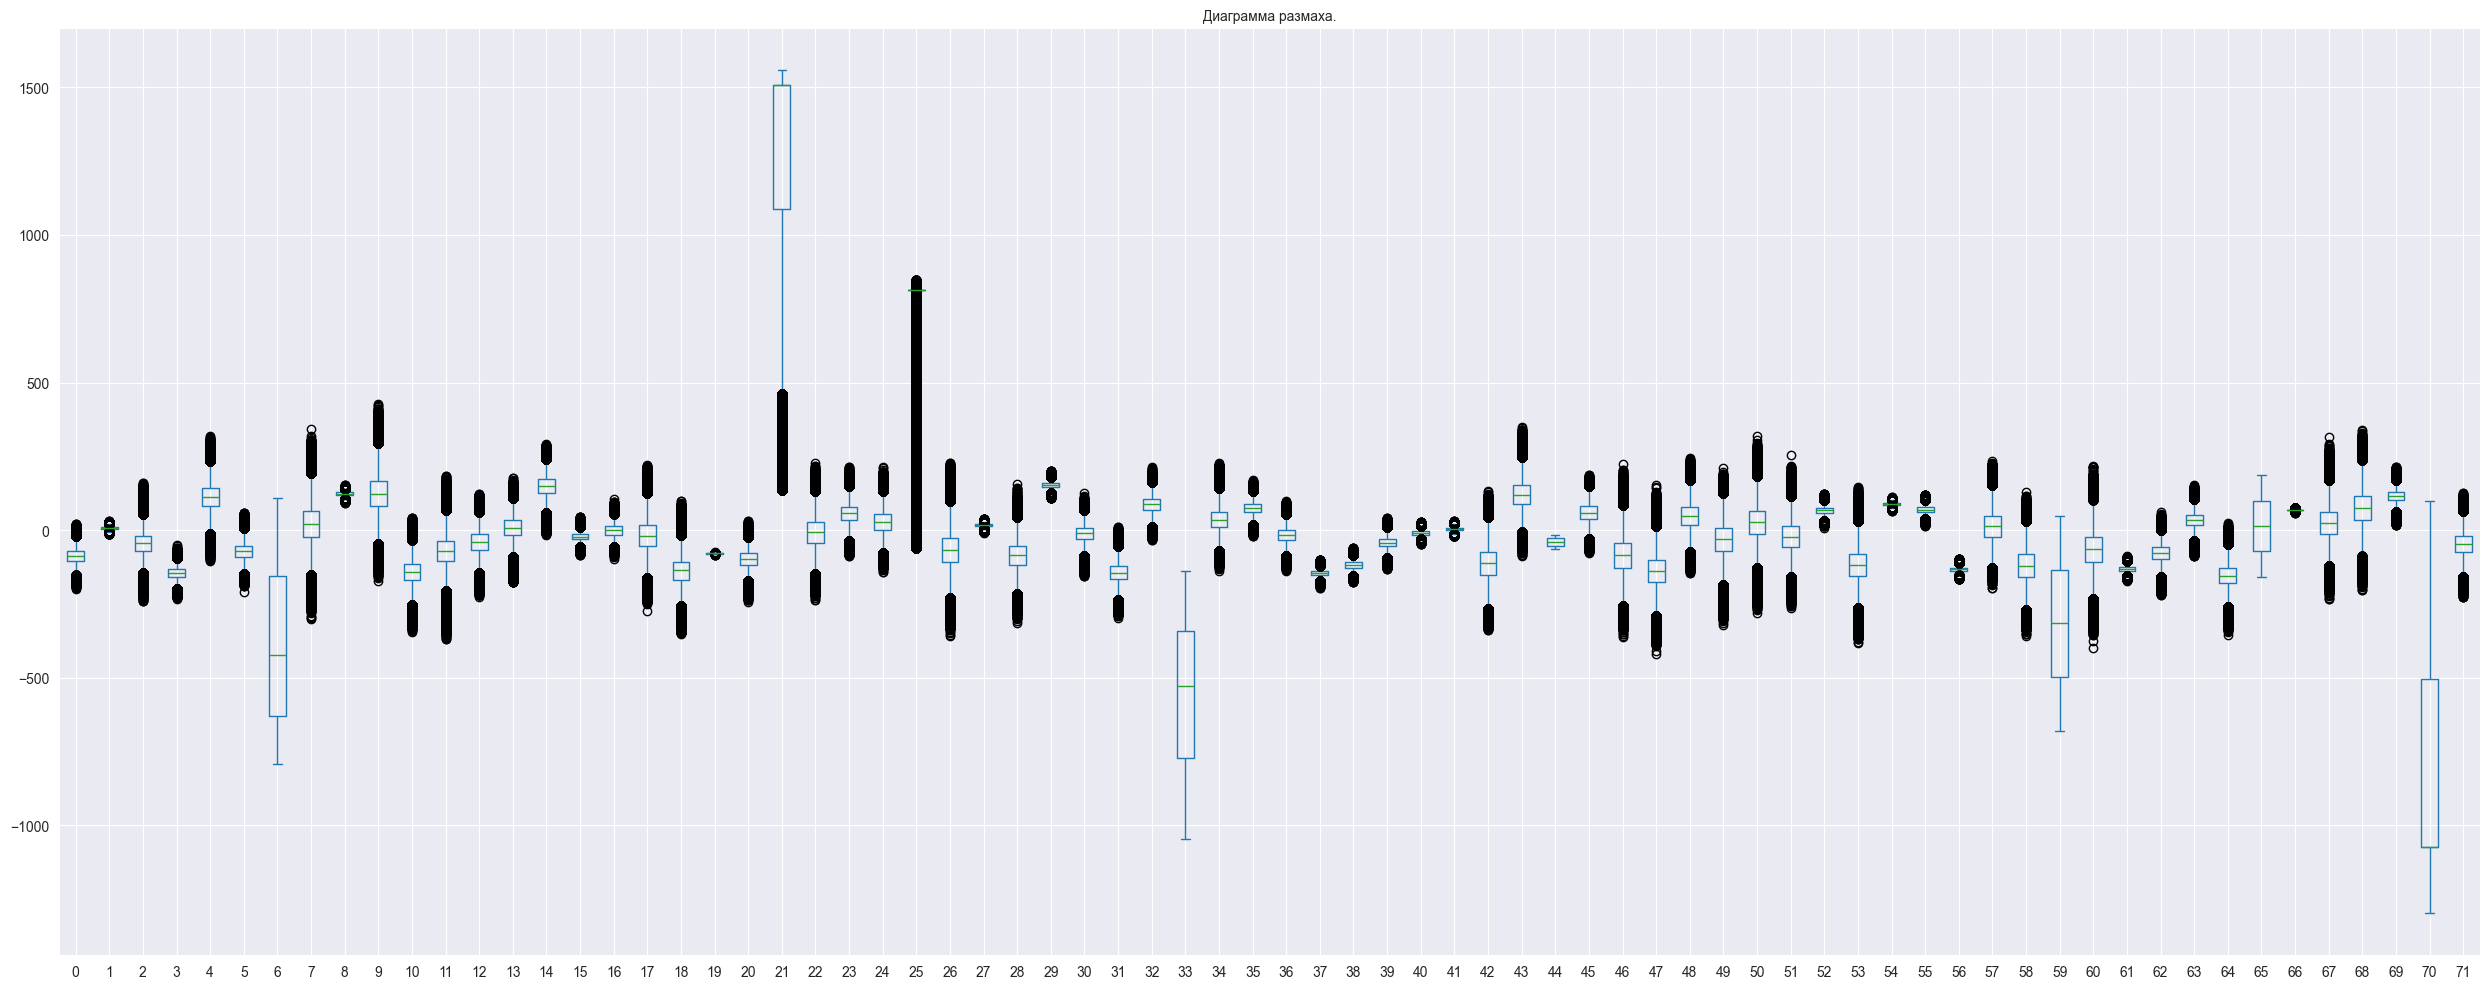

In [15]:
# Посмотрю на выбросы в данных
show_outliers(df_base)

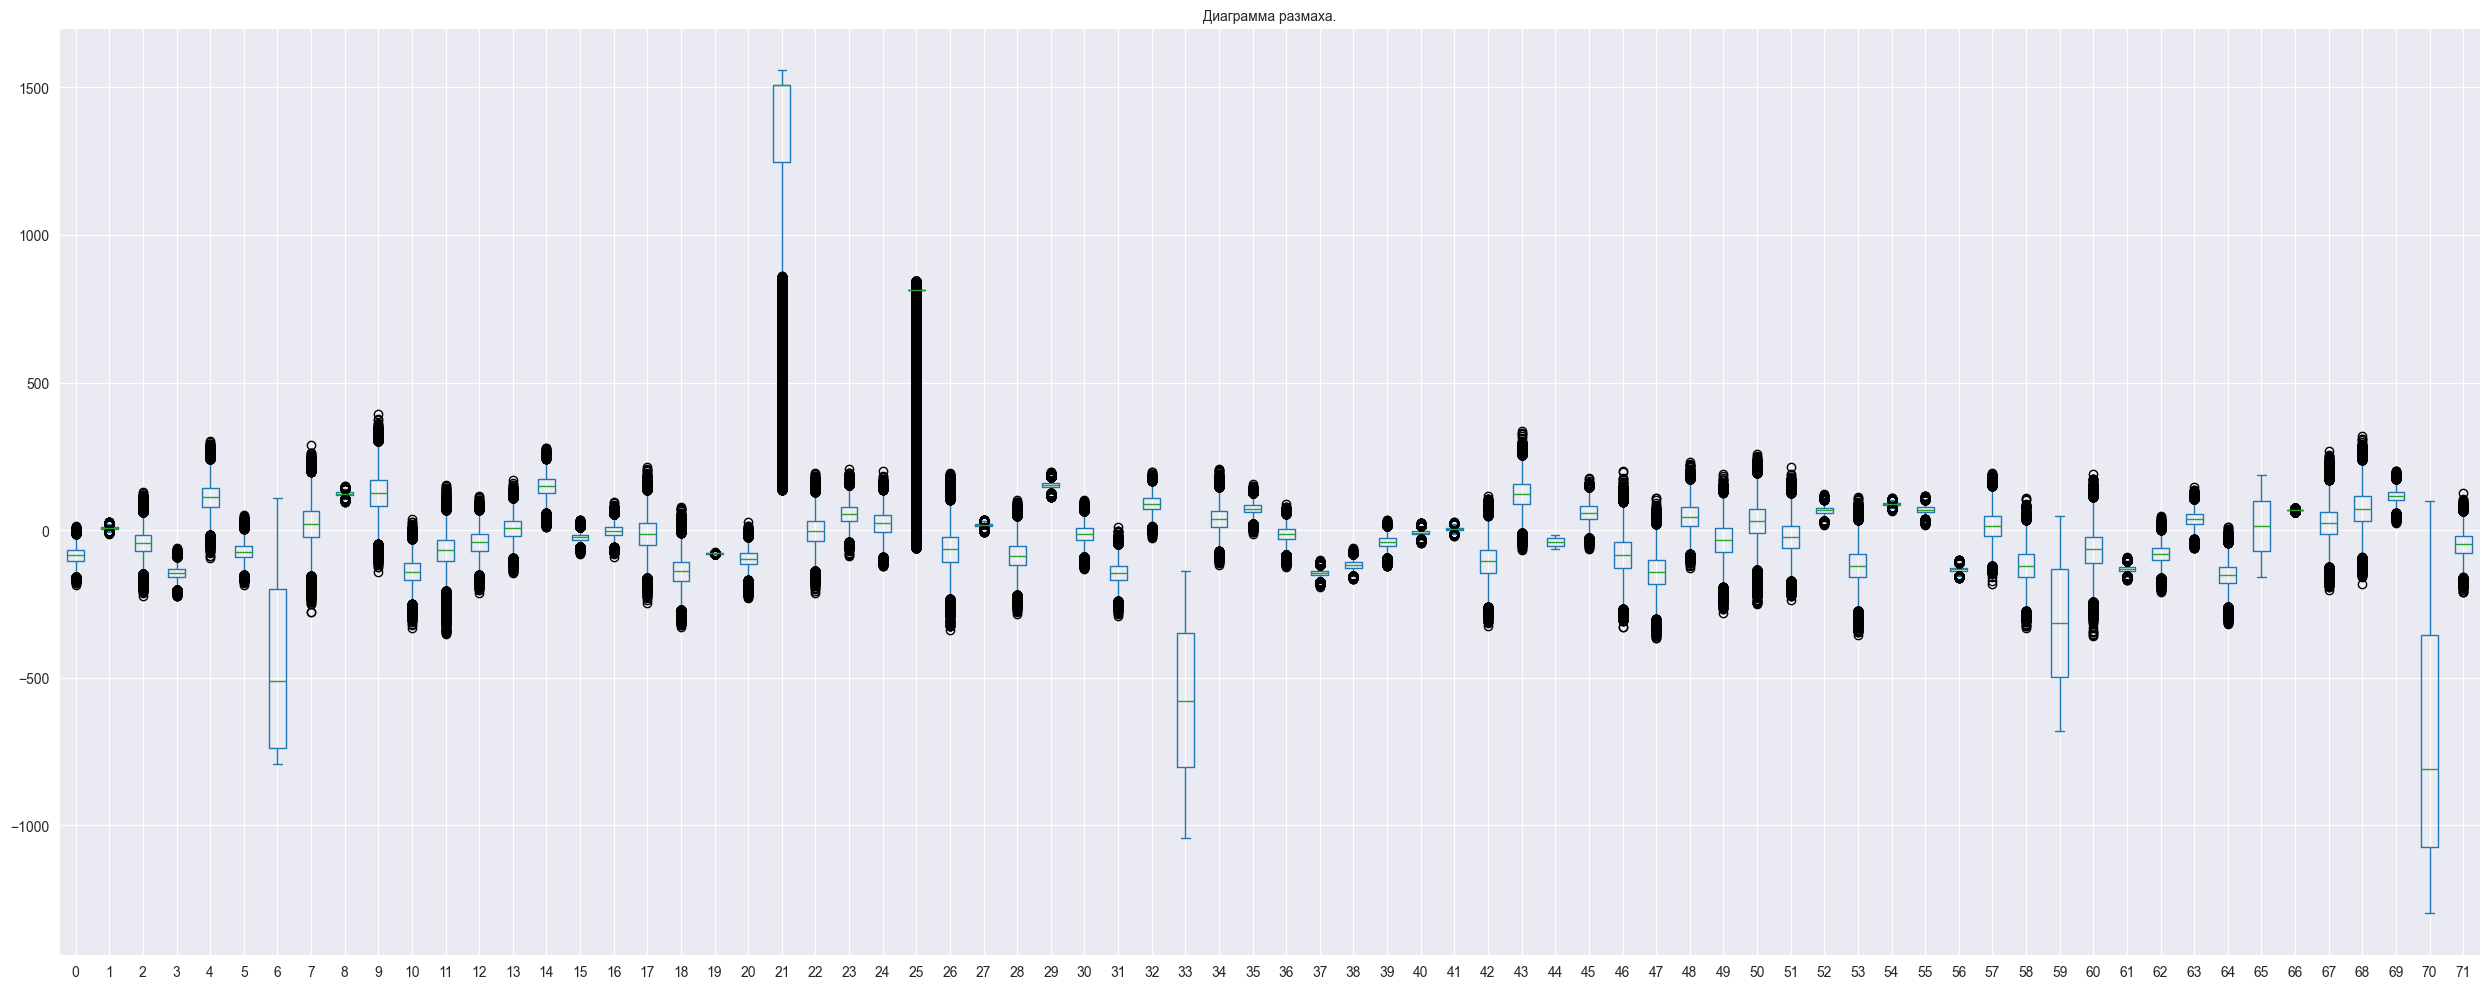

In [16]:
show_outliers(df_train)

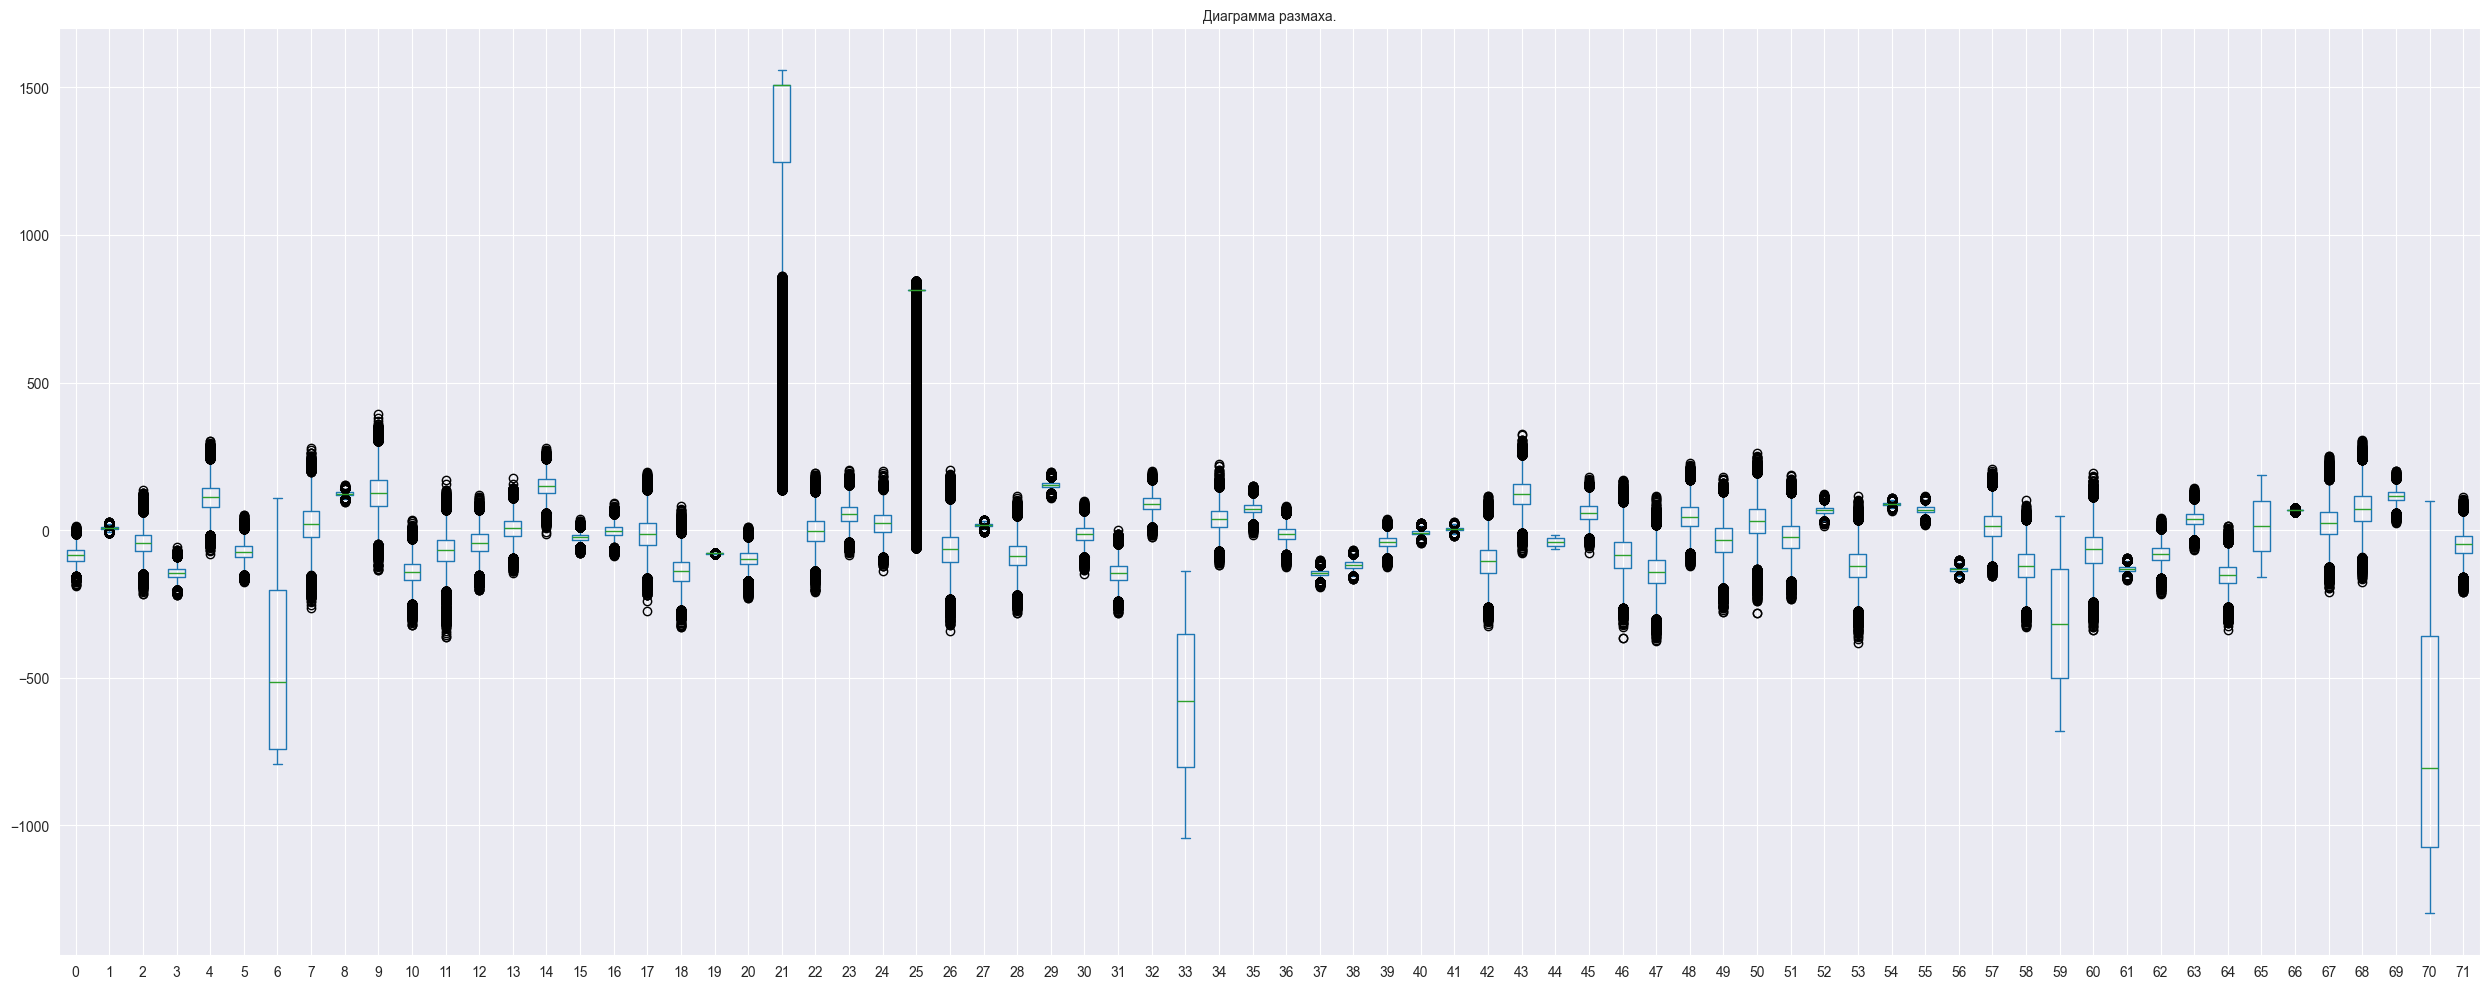

In [17]:
show_outliers(df_test)

Практически у всех признаков имеются выбросы. 
Колонки, на которые ранее обратил внимание, тоже ведут себя на этих графиках отлично от остальных признаков. 

In [18]:
# Метрика с RobustScaler без удаления выбросов показывает лучшие значения, чем с удалением оных. В связи с этим не буду удалять выбросы. 
# for df in [df_train, df_base, df_test]:
#     removing_outliers(df)

In [19]:
# функция вычисления accuracy@n
def accuracy_n(train_df:pd.DataFrame, 
               base_df:pd.DataFrame,
               targets=train_targets,
               base_index_=base_index,
               idx=None):

    accuracy = 0
    start = time.time()
    
    index_ = idx
    index_.reset()
    if type(index_) == faiss.swigfaiss.IndexIVFFlat:
        index_.nprobe = 55
        index_.nlist = 55 
        # при этих показателях у данного индекса максимальное значение метрики
        
    # index_.train(base_df)
    # index_.add(base_df)
    # _, indexes_ = index_.search(train_df, K)
    
    index_.train(np.ascontiguousarray(base_df))
    index_.add(np.ascontiguousarray(base_df))
    _, indexes_ = index_.search(np.ascontiguousarray(train_df), K)

    for target, predicted in zip(targets.tolist(), indexes_.tolist()):
        accuracy += int(target in [base_index_[number] for number in predicted])

    return accuracy / len(indexes_) * 100, round(time.time() - start, 2)

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Это не просто функция точности, это еще обучение индекса внутри. Так луше не делать. Индекс и обучение отдельно, метрики отдельно. И почему именно такие параметры индекса? 55? :)</div>


In [20]:
acc, _ = accuracy_n(df_train, df_base, idx=faiss.IndexFlatL2(df_base.shape[1]))
print(f'Метрика базовой модели без воздействий на признаки составляет {acc}')

Метрика базовой модели без воздействий на признаки составляет 13.804


In [21]:
# Посмотрю на изменения показаний метрики при удалении признаков
res_list = []
cols_for_drop = ['6', '21', '25', '33', '59', '44', '65', '70']

df_train_drop = df_train.copy()
df_base_drop = df_base.copy()

for col in tqdm(cols_for_drop):
    df_train_drop.drop(col, axis=1, inplace=True)
    df_base_drop.drop(col, axis=1, inplace=True)

    index = faiss.IndexFlatL2(df_base_drop.shape[1])

    acc, time_ = accuracy_n(df_train_drop, df_base_drop, idx=index)
    res_list.append([col, acc, time_])

columns = ['Удаленный признак', 'accuracy@5', 'Время (сек.)']
result = pd.DataFrame(res_list, columns=columns)
display(result)

del df_train_drop, df_base_drop

 38%|███▊      | 3/8 [38:29<1:04:09, 769.84s/it]


KeyboardInterrupt: 

In [22]:
# Удалю рассмотренные признаки, которые ведут себя аномально, оставив колонки №№ 6 и 70. При их удалении метрика меняется в худшую сторону. 
for df in [df_train, df_base, df_test]:
    df.drop(['21', '25', '33', '59', '44', '65'], axis=1, inplace=True, errors='ignore')

### Промежуточный вывод. 
Данные не имеют пропусков и дубликатов. 
Признаки 6, 21, 25, 33, 44, 59, 65, 70 имеют ненормальное распределение. Остальные признаки имеют нормальное или близкое к нормальному распределение.
Корреляция признаков отсутствует.
Данные имеют выбросы. 

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>👍 </div>
    


[К оглавлению](#section_0)
<a id='section_3'></a>
## Подготовка и выбор моделей  

In [23]:
# Подберу скалер для трансформации данных. 
all_scaler = [
    MinMaxScaler(), MaxAbsScaler(), PowerTransformer(),
    QuantileTransformer(), RobustScaler()
]

res_list = []

for scal in tqdm(all_scaler):
    scaler = scal
    base_transform  = scaler.fit_transform(df_base)
    train_transform = scaler.transform(df_train)
    index = faiss.IndexFlatL2(base_transform.shape[1])

    acc, time_ = accuracy_n(train_transform, base_transform, idx=index)
    res_list.append([scal, acc, time_])

columns = ['Scaler', 'accuracy@5', 'Время (сек.)']
result = pd.DataFrame(res_list, columns=columns)
result.sort_values(by='accuracy@5', ascending=False)

100%|██████████| 5/5 [52:09<00:00, 625.88s/it]


,Scaler,accuracy@5,Время (сек.)
2,PowerTransformer(),71.9690,619.6800
4,RobustScaler(),71.9450,426.3700
3,QuantileTransformer(),71.4400,494.1300
1,MaxAbsScaler(),66.4930,588.0600
0,MinMaxScaler(),64.6540,749.9700


RobustScaler 71.9450 
PowerTransformer 71.879
StandardScaler 71.876
QuantileTransformer 71.446
MinMaxScaler 71.01
MaxAbsScaler 70.16

Наилучшие показатели метрики у RobustScaler. Применю его к данным. 

In [24]:
scaler = RobustScaler()

base_transform  = scaler.fit_transform(df_base)
train_transform = scaler.transform(df_train)
test_transform = scaler.transform(df_test)

100%|██████████| 7/7 [41:56<00:00, 359.55s/it]


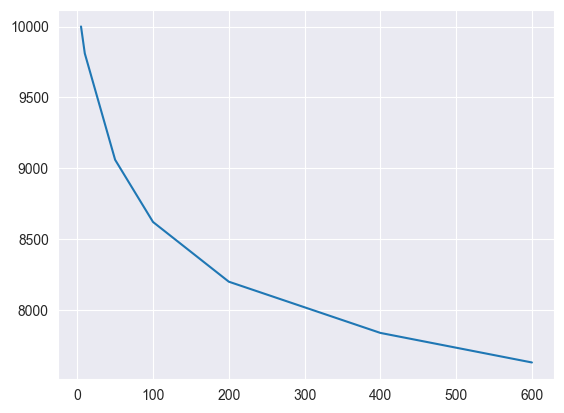

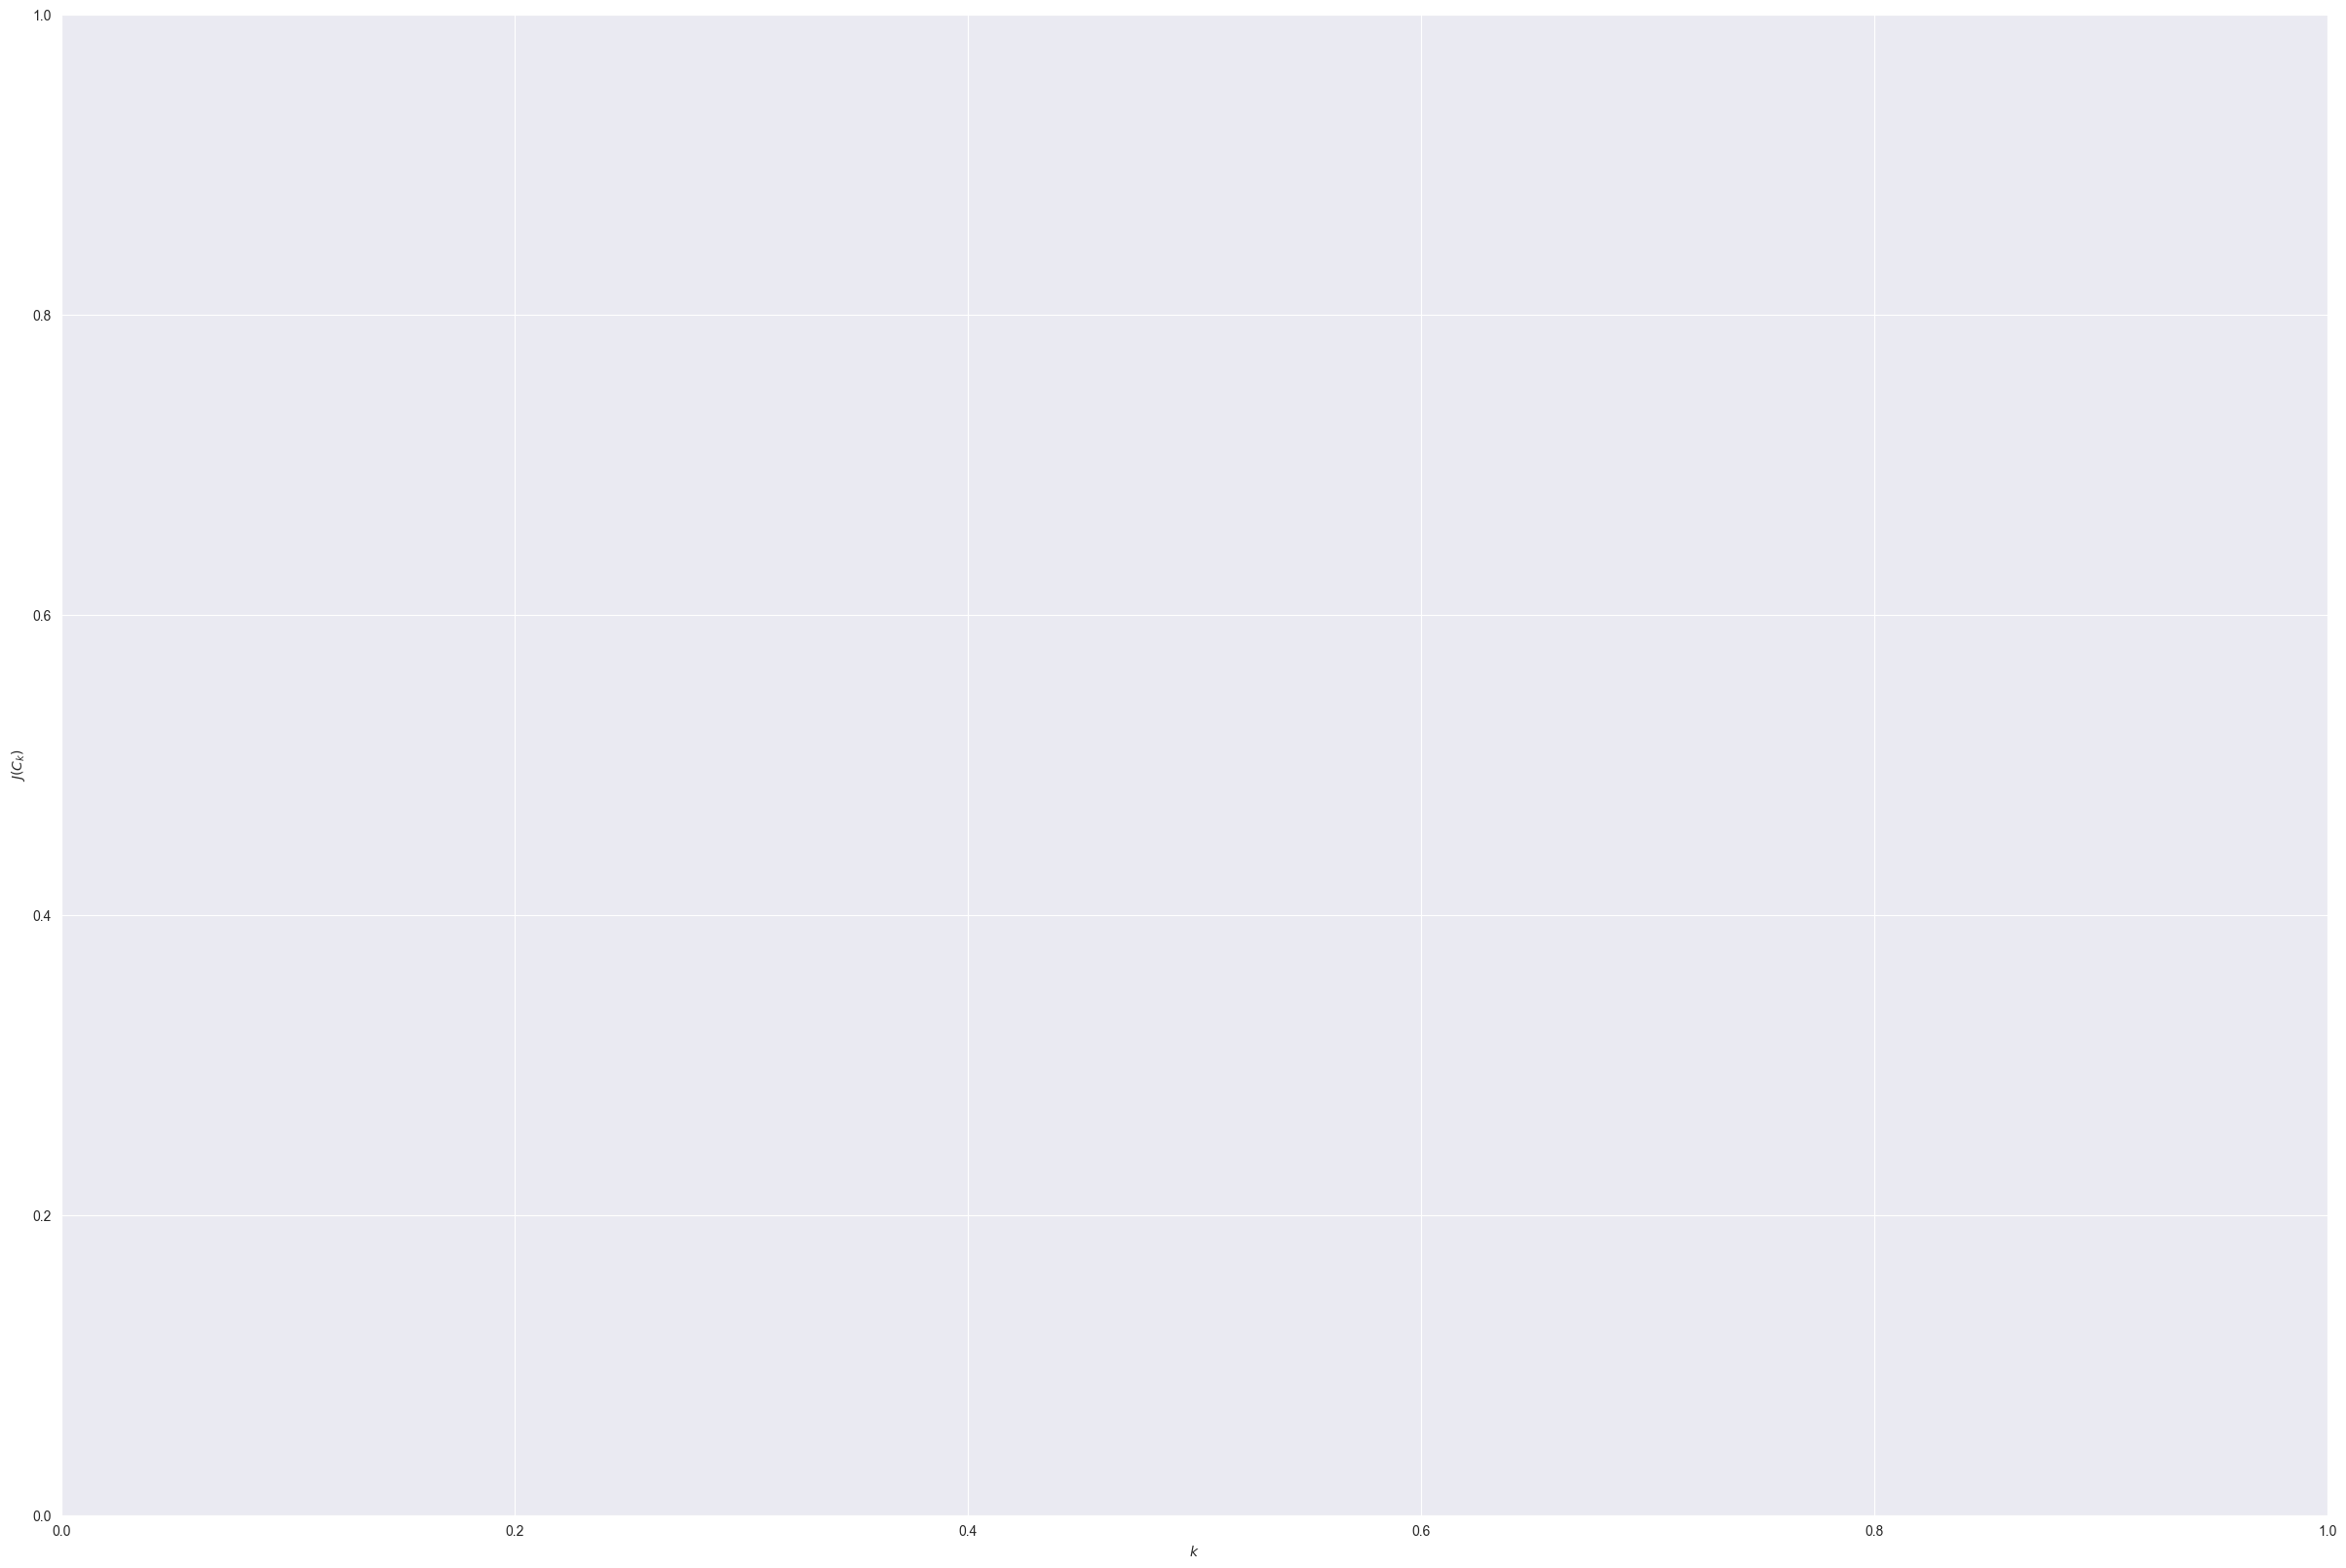

In [25]:
# Выбор числа кластеров по методу "локтя"

inertia = []
n_clusters = [5, 10, 50, 100, 200, 400, 600]

for i in tqdm(n_clusters):
    kmeans = KMeans(n_clusters=i, 
                    random_state=RANDOM_STATE, 
                    init='k-means++',
                    n_init='auto',
                    algorithm='elkan',
                    ).fit(base_transform)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(n_clusters, inertia)
plt.figure(figsize=(30, 20))
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> А зачем нам метод локтя в даннам случае? Не совсем понятна логика</div>
 


 Заметен излом кривой на 200 кластерах. 

In [ ]:
# Вычисление кол-ва кластеров

def get_clusters_coeff(df:pd.DataFrame, n_clusters:list):
    if isinstance(n_clusters, int):
        n_clusters = [n_clusters]

    for i in tqdm(n_clusters):
        cluster_k = KMeans(n_clusters=i,
                           n_init='auto',
                           init='k-means++',
                           random_state=RANDOM_STATE).fit(df)
        # Разделим на i кластеров
        db_score = davies_bouldin_score(df, cluster_k.labels_)
        print(f'{i} кластеров: {round(db_score, 4)}')

In [ ]:
%%time
get_clusters_coeff(df=base_transform, 
                   n_clusters=[5, 10, 25, 50, 100, 200, 400, 600])

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Это все хорошо, но как это относится к фаиссу? </div>
 


И поиск кластеров коэффициентом схожести Девида-Боулдина также показвает на 200 кластеров. 
<br>
### Рассмотрение различных индексов FAISS

In [ ]:
dimension = base_transform.shape[1]

In [ ]:
np.sqrt(base_transform.shape[0])

In [ ]:
res_list = []
nlists = np.sqrt(base_transform.shape[0])
quantizer = faiss.IndexFlatL2(dimension)

ind = {'IndexFlatL2': faiss.IndexFlatL2(dimension),
       'IndexIVFFlat': faiss.IndexIVFFlat(quantizer, dimension, nlists),
       'IndexHNSWFlat': faiss.IndexHNSWFlat(dimension, K),
       'IndexIVFPQ': faiss.IndexIVFPQ(quantizer, dimension, nlists, 11, 8),
       'IndexPQ': faiss.IndexPQ(dimension, 11, 8),
       'IndexLSH': faiss.IndexLSH(dimension, 8),
       'IndexFlatIP': faiss.IndexFlatIP(dimension),
       }

for k, v in tqdm(ind.items()):
    acc, time_ = accuracy_n(train_transform, base_transform, idx=v)
    res_list.append([k, acc, time_])

columns = ['Index', 'accuracy@5', 'Время (сек.)']
result = pd.DataFrame(res_list, columns=columns)
result.sort_values(by='accuracy@5', ascending=False)

<div class="alert alert-warning">
<b>Комментарий ревьюера ⚠️:</b> Ага, теперь понял. nlists выбирается не так как ты сделал, nlists - это просто корень и количества примеров для обучния индекса. В твоем случае - np.sqrt(base_transform.shape[0])  </div>
 


Наилучшие показатели у индексов ***IndexIVFFlat*** и ***IndexFlatL2***, но при этом ***IndexFlatL2*** работает в 10 раз быстрее, а результат у него отличается всего на 2 тысячных.
При таких показателях выберу для дальнейшей работы ***IndexFlatL2***

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>👍 </div>
    




[К оглавлению](#section_0)
<a id='section_4'></a>
## Уменьшение размерности  

Попробую уменьшить размерность и посмотрю на результаты. 

In [ ]:
# Создаем экземпляр PCA
pca = PCA(n_components=None,
          whiten=True,
          random_state=RANDOM_STATE).fit(base_transform)

ipca = IncrementalPCA(n_components=None,
                      whiten=True,
                      batch_size=100).fit(base_transform)

# Строим график объясненной дисперсии
evr_ipca = ipca.explained_variance_ratio_
evr_pca = pca.explained_variance_ratio_

plt.plot(range(1, len(evr_ipca) + 1), evr_ipca, marker='o', color='darkorange')
plt.plot(range(1, len(evr_pca) + 1), evr_pca, marker='X', color='navy')

plt.xlabel("Число компонент")
plt.ylabel("Доля объясненной дисперсии")
plt.title("Метод локтя для выбора числа компонент")
plt.show()

In [ ]:
pca = PCA(n_components=dimension,
          whiten=True,
          random_state=RANDOM_STATE).fit(base_transform)

acc, time_ = accuracy_n(
    pca.transform(train_transform), 
    pca.transform(base_transform),
    idx=faiss.IndexFlatL2(dimension)
)
print(f'accuracy@5 = {acc}, время выполнения = {time_} секунд.')

In [ ]:
ipca = IncrementalPCA(n_components=dimension,
                      whiten=True,
                      batch_size=100).fit(base_transform)

acc, time_ = accuracy_n(
    ipca.transform(train_transform),
    ipca.transform(base_transform),
    idx=faiss.IndexFlatL2(dimension)
)
print(f'accuracy@5 = {acc}, время выполнения = {time_} секунд.')

In [ ]:
svd = TruncatedSVD(n_components=dimension,
                   random_state=RANDOM_STATE).fit(base_transform)

acc, time_ = accuracy_n(
    svd.transform(train_transform),
    svd.transform(base_transform),
    idx=faiss.IndexFlatL2(dimension)
)
print(f'accuracy@5 = {acc}, время выполнения = {time_} секунд.')

Эксперименты с уменьшением размерности не дали улучшения метрики. 

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Но попробовать стоило, хороший эксперимент </div>
    




[К оглавлению](#section_0)
<a id='section_5'></a>
## Проверка на Валидационной выборке

Проверю результат на валидационных данных. 

In [ ]:
acc, time_ = accuracy_n(
    test_transform,
    base_transform,
    targets=ans['Expected'],
    idx=faiss.IndexFlatL2(dimension)
)
print(f'accuracy@5 = {acc}, время выполнения = {time_} секунд.')

In [ ]:
nlists = 1700
quantizer = faiss.IndexFlatL2(dimension)

acc, time_ = accuracy_n(
    test_transform,
    base_transform,
    targets=ans['Expected'],
    idx=faiss.IndexIVFFlat(quantizer, dimension, nlists)
)
print(f'accuracy@5 = {acc}, время выполнения = {time_} секунд.')

# accuracy@5 = 71.797, время выполнения = 2221.57 секунд.

[К оглавлению](#section_0)
<a id='section_6'></a>
## Итоговый вывод

Значение целевой метрики ***accuracy@5 = 71.798*** было получено с использованием модели **FAISS** с индексом `IndexFlatL2`.
Масштабирование было выполнено с применением *RobustScaler*. 
Признаки с ненормальным распределением были удалены, за исключением двух, удаление которых неблагоприятно влияло на метрику (6 и 70).
Попытка уменьшить размерность не привела к улучшению результата. 

<div class="alert alert-success">
<h2>Заключение ревьювера: </h2> 


Владимир, у тебя получился очень крутой проект, все выполнено на высочайшем уровне! 


✅ По оформлению работы: Все выполнено аккуратно и со знанием дела, однако старайся разделять функции качества от функций обучения моделей. В остальном по оформлению все отлично. 
    
✅ Предобработка данных: Здесь все ок👌🏼
    
✅ Обучение модели: Эксперименты проведены хорошо, однако ты немного перепутал параметр а фаисс, но в целом это сильно на метрики не влияет. В дальнейшем можешь попробовать обучить ранжировщик выдачи фаисса, чтобы еще поднять метрики. 
        
**Было приятно с тобой поработать:)**
